In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
usage_df = pd.read_csv('mono_c.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
0,93512,Mono County,1,2015,Residential,66924.0,0.066924
1,93512,Mono County,1,2015,Commercial,23786.0,0.023786
2,93517,Mono County,1,2015,Residential,248613.0,0.248613
3,93517,Mono County,1,2015,Commercial,825840.0,0.825840
4,93529,Mono County,1,2015,Residential,441114.0,0.441114


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ZipCode        1051 non-null   int64  
 1   County         1051 non-null   object 
 2   Month          1051 non-null   int64  
 3   Year           1051 non-null   int64  
 4   CustomerClass  1051 non-null   object 
 5   TotalkWh       1051 non-null   float64
 6   TotalGWh       1051 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 57.6+ KB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ZipCode        1051 non-null   int64         
 1   County         1051 non-null   object        
 2   Month          1051 non-null   int64         
 3   Year           1051 non-null   int64         
 4   CustomerClass  1051 non-null   object        
 5   TotalkWh       1051 non-null   float64       
 6   TotalGWh       1051 non-null   float64       
 7   Date           1051 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 65.8+ KB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,93512,Mono County,1,2015,Residential,66924.0,0.066924
2015-01-01,93512,Mono County,1,2015,Commercial,23786.0,0.023786
2015-01-01,93517,Mono County,1,2015,Residential,248613.0,0.248613
2015-01-01,93517,Mono County,1,2015,Commercial,825840.0,0.825840
2015-01-01,93529,Mono County,1,2015,Residential,441114.0,0.441114


## Resampling dataframe to total monthly usage

In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,15997131.0,15.997131
2015-02-28,12494364.0,12.494364
2015-03-31,11768277.0,11.768277
2015-04-30,10590259.0,10.590259
2015-05-31,9487139.0,9.487139


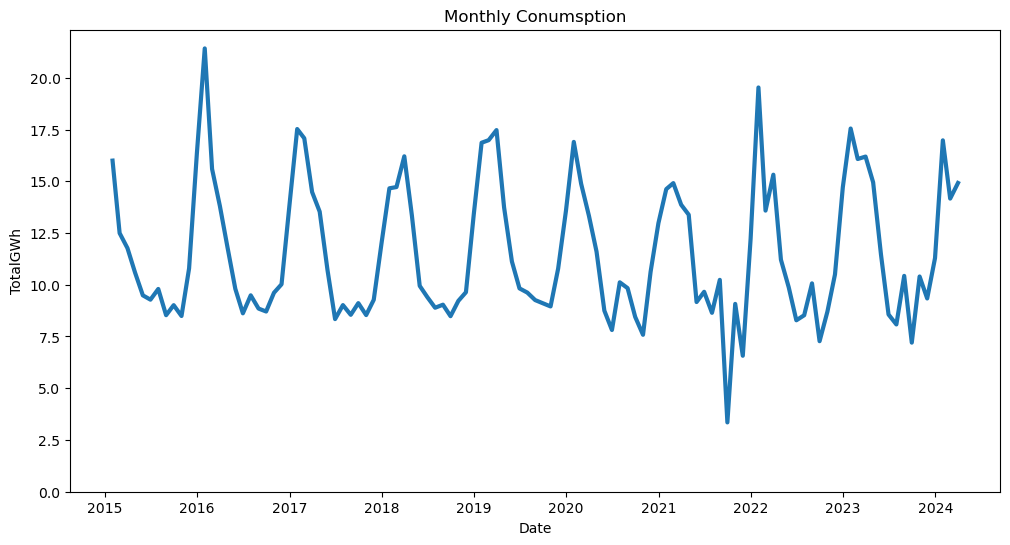

In [13]:
# PLotting data
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], linewidth=3)
plt.title("Monthly Conumsption")
plt.xlabel("Date")
plt.ylabel("TotalGWh")
plt.ylim(ymin=0)
plt.show()

## Implementing SARIMA model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Checking for stationarity of data

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(usage['TotalGWh'])

ADF Statistic: -2.288745840287718
p-value: 0.17562335634665033
Non-Stationary


***SARIMAX model can still handle non-stationary data***

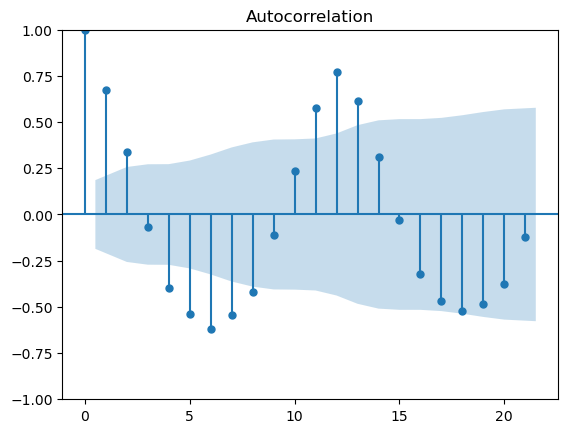

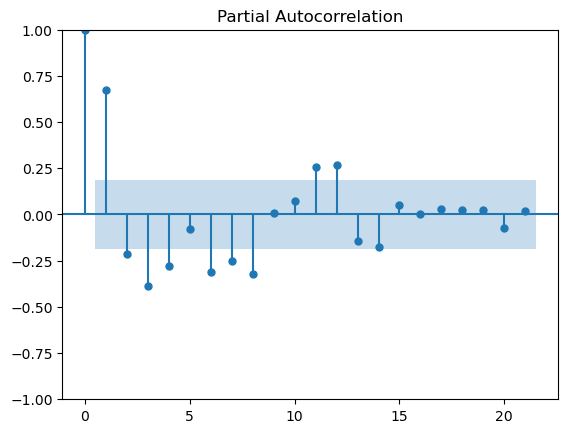

In [16]:
 # Plot ACF and PACF
plot_acf(usage['TotalGWh'])
plot_pacf(usage['TotalGWh'])
plt.show()

## Using AutoArima to find the parameters for SARIMAX model

In [17]:
# Install the library if necessary
# !pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(usage['TotalGWh'],
                   test='adf',
                   seasonal=True,
                   #max_p=3, max_q=3,
                   start_p=0,
                   d=1,
                   trace=True,
                   start_P=0,
                   m=12,
                   #D=None,
                   stepwise=True,
                   with_intercept=True,
                   suppress_warnings=True)

model.fit(usage['TotalGWh'])

# Check the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=502.365, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=523.656, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=461.642, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=502.448, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=521.658, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=525.467, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=439.537, Time=0.18 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=501.739, Time=0.07 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=441.433, Time=0.49 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=441.448, Time=0.48 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=482.864, Time=0.22 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=458.992, Time=0.13 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AI

In [18]:
# p, d, q parameters
model.order

(0, 1, 1)

In [19]:
# P, D, Q, s parameters
model.seasonal_order

(1, 0, 1, 12)

In [20]:
# Define SARIMA parameters from AutoArima results

# Fit the SARIMA model
model = SARIMAX(usage['TotalGWh'], order=model.order, seasonal_order=model.seasonal_order)
results = model.fit()
model

### Forecasting the next 12 months

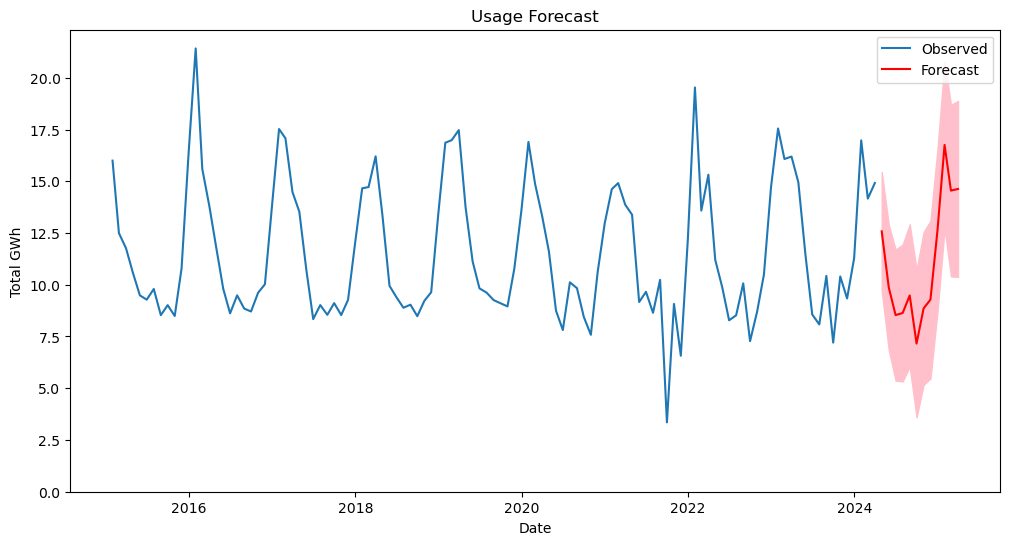

In [21]:
# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

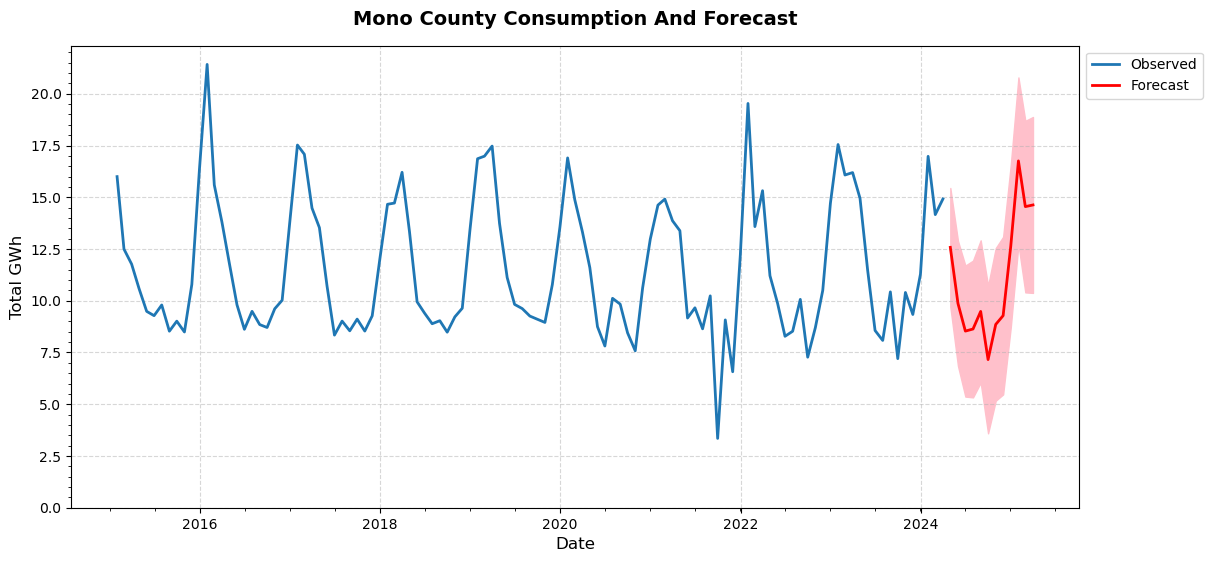

In [22]:
# Alternative Plot
from matplotlib.ticker import AutoMinorLocator


# Plot settings
plt.figure(figsize=(13, 6))
ax1 = sns.lineplot(data=usage['TotalGWh'], label='Observed',linewidth=2)
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='red', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')


# Plot labels and legend
plt.title("Mono County Consumption And Forecast", weight='bold', fontsize=14, pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(bottom=0)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.13,1), loc='upper right')

# Show plot
plt.savefig('mono_c.png')
plt.show()

### Evaluate Model

In [23]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 0.7823348635841424
MSE: 1.1554847654606497
RMSE: 1.0749347726539735


In [24]:
observed

Date
2023-04-30    14.949517
2023-05-31    11.465633
2023-06-30     8.563039
2023-07-31     8.082439
2023-08-31    10.427900
2023-09-30     7.203591
2023-10-31    10.399644
2023-11-30     9.336876
2023-12-31    11.287327
2024-01-31    16.976935
2024-02-29    14.162136
2024-03-31    14.917386
Freq: M, Name: TotalGWh, dtype: float64

In [25]:
forecast_mean

2024-04-30    12.579737
2024-05-31     9.869439
2024-06-30     8.533820
2024-07-31     8.634590
2024-08-31     9.483434
2024-09-30     7.157350
2024-10-31     8.855643
2024-11-30     9.281187
2024-12-31    12.641554
2025-01-31    16.755691
2025-02-28    14.547735
2025-03-31    14.628177
Freq: M, Name: predicted_mean, dtype: float64

### Forecasting the next 24 months

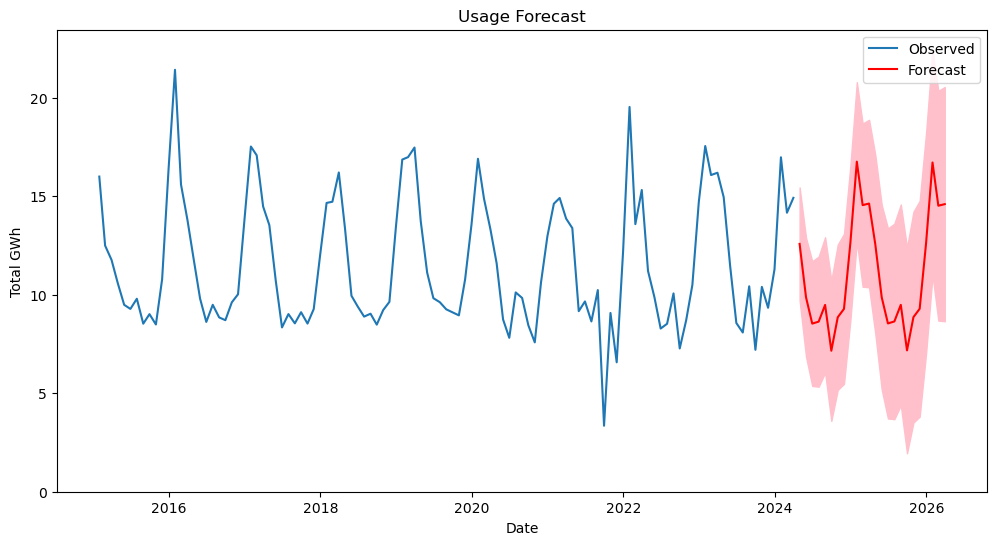

In [26]:
# Forecast future demand
forecast_periods = 24  # Forecast the next 24 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

### Evaluate Model

In [27]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 0.7982335866188665
MSE: 1.1420662967411845
RMSE: 1.0686750192369916


In [28]:
observed

Date
2022-04-30    11.209320
2022-05-31     9.871349
2022-06-30     8.282683
2022-07-31     8.526084
2022-08-31    10.066088
2022-09-30     7.273353
2022-10-31     8.701721
2022-11-30    10.500671
2022-12-31    14.712764
2023-01-31    17.547865
2023-02-28    16.075151
2023-03-31    16.192454
2023-04-30    14.949517
2023-05-31    11.465633
2023-06-30     8.563039
2023-07-31     8.082439
2023-08-31    10.427900
2023-09-30     7.203591
2023-10-31    10.399644
2023-11-30     9.336876
2023-12-31    11.287327
2024-01-31    16.976935
2024-02-29    14.162136
2024-03-31    14.917386
Freq: M, Name: TotalGWh, dtype: float64

In [29]:
forecast_mean

2024-04-30    12.579737
2024-05-31     9.869439
2024-06-30     8.533820
2024-07-31     8.634590
2024-08-31     9.483434
2024-09-30     7.157350
2024-10-31     8.855643
2024-11-30     9.281187
2024-12-31    12.641554
2025-01-31    16.755691
2025-02-28    14.547735
2025-03-31    14.628177
2025-04-30    12.562888
2025-05-31     9.869937
2025-06-30     8.542866
2025-07-31     8.642992
2025-08-31     9.486403
2025-09-30     7.175206
2025-10-31     8.862630
2025-11-30     9.285450
2025-12-31    12.624309
2026-01-31    16.712114
2026-02-28    14.518290
2026-03-31    14.598218
Freq: M, Name: predicted_mean, dtype: float64

In [30]:
customer_consum = usage_df.groupby('CustomerClass')['TotalGWh'].sum()
customer_consum

CustomerClass
Agricultural     25.491859
Commercial      533.935404
Residential     720.838950
Name: TotalGWh, dtype: float64

In [31]:
customer_df = customer_consum.reset_index()
customer_df

,CustomerClass,TotalGWh
0,Agricultural,25.491859
1,Commercial,533.935404
2,Residential,720.838950


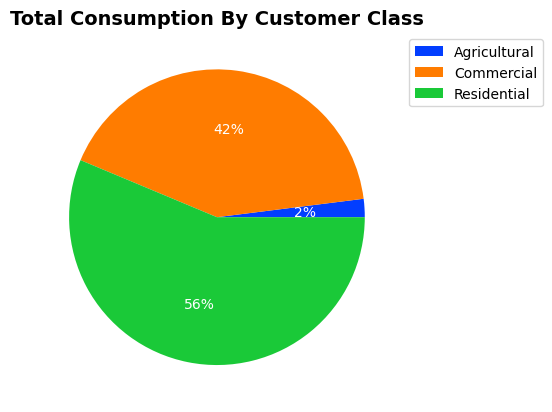

In [32]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='w'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

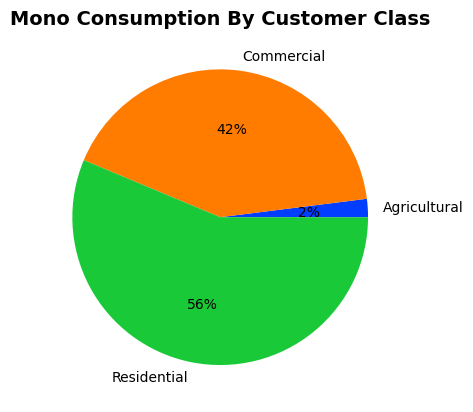

In [33]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='black'))
plt.title('Mono Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
#plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

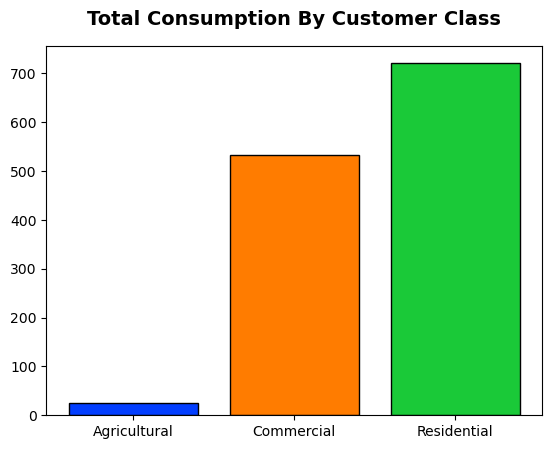

In [34]:
# Bar chart
plt.bar(customer_df['CustomerClass'],customer_df['TotalGWh'], color=palette_color,edgecolor='black', )
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center', pad=15)
plt.show()